In [1]:
from calibration_config import *
from tti_models.analyzers.alternative_fit import FitGrowthRate
from tti_models.infectiousness_profiles import FerrettiInfectionDynamics
import covasim as cv
from contact_matrices import contact_scenarios
from functools import partial
import seaborn as sns 
from scipy.optimize import minimize_scalar
import statsmodels.api as sm
from patsy import dmatrices
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy
sns.set()

Covasim 3.0.2 (2021-04-26) — © 2021 by IDM


In [2]:
# calibration wide settings
# because I keep changing things
starting_infections = 100
contact_scenario = 'September2020'
pop_size = 100000

short_simulation_time = 60 # no need to run full simulations to estimate growth rates
full_simulation_time = 180 # used to assess full epidemics 

## Model Calibration Notebook
We aim to simulate growing epidemics for all interventions, for two different contact scenarios: July2020, and March2021.

Initially, we focus on finding an upper and lower bound for beta. This is achieved by plotting sample epidemics, and finding time periods where we can conistently estimate the gorwth rate of the epidemic without significant suscpeitble depletion.

In [3]:
def run_simulation(beta: float, starting_infections: int, contact_scenario: str, pop_size: float, n_days: int, rand_seed: int):
    """Runs a simulation for a trial and returns a growth rate object

    Args:
        beta (float): trial 
        starting_infections (int): [description]
        contact_scenario (str): [description]
        pop_size (float): population size to trial

    Returns:
        FitGrowthRate: simulation growth rate analyzer object
    """

    ferretti_infectiousness = FerrettiInfectionDynamics()

    input_pars = copy(sim_pars)
    input_pars['pop_size'] = pop_size
    input_pars['beta'] = beta
    input_pars['n_days'] = n_days
    input_pars['rand_seed'] = rand_seed

    sim = cv.Sim(input_pars,
                pop_infected = starting_infections,
                infection_dynamics = ferretti_infectiousness,
                contact_matrices = contact_scenarios[contact_scenario],
                verbose = 0)

    sim.run()

    # pass to the objective function to evaluate the mismatch
    return FitGrowthRate(sim, growth_rate=0.0)

## Finding an appropiate upper bound

In [47]:
samples = [
    run_simulation(beta = 2, starting_infections=starting_infections, contact_scenario=contact_scenario, pop_size=pop_size, n_days=short_simulation_time, rand_seed=_)
    for _ in range(5)
]

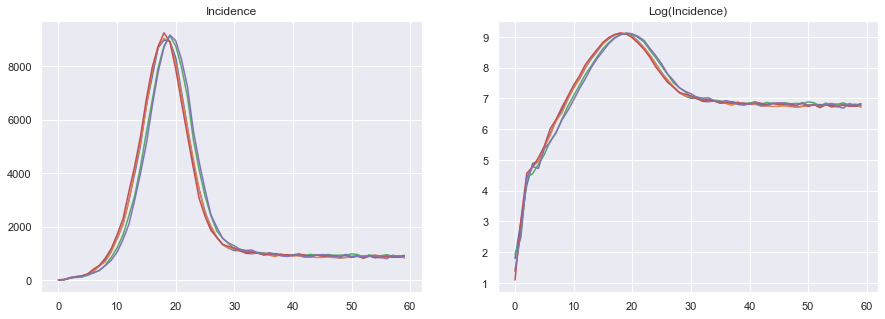

In [48]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

axs[0].set_title('Incidence')
axs[1].set_title('Log(Incidence)')

n_days = short_simulation_time

for epidemic in samples:

    cases = epidemic.get_cases(day_from=0, day_to=n_days)

    axs[0].plot(range(len(cases)), cases)
    axs[1].plot(range(len(cases)), np.log(cases))

plt.show()

Inspection of the plots suggest that the growth rate is practically constant from day 10 to 30. Afterwards, there is slight susceptible depletion which becomes quite severe around days 40. We estimate the growth rate using days 10 to 30.

In [49]:
for epidemic in samples:
    epidemic.estimate_growth_rate(day_from=5, day_to=15)

growth_rates = [epidemic.estimated_growth_rate for epidemic in samples]

growth_rates

[0.2918822796128567,
 0.3002603127577941,
 0.3057365671504099,
 0.28995945548399604,
 0.30334711464982944]

In [50]:
np.mean(growth_rates)

0.2982371459309773

## Finding an appropiate lower bound

In [46]:
samples = [
    run_simulation(beta = 0.45, starting_infections=starting_infections, contact_scenario=contact_scenario, pop_size=pop_size, n_days=short_simulation_time, rand_seed=_)
    for _ in range(5)
]

KeyboardInterrupt: 

In [ ]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

axs[0].set_title('Incidence')
axs[1].set_title('Log(Incidence)')

n_days = 60

for epidemic in samples:

    cases = epidemic.get_cases(day_from=0, day_to=n_days)

    axs[0].plot(range(len(cases)), cases)
    axs[1].plot(range(len(cases)), np.log(cases))

plt.show()

Inspection of the plots suggest that the growth rate is practically constant from day 10 to 60. Afterwards, there is slight susceptible depletion which becomes quite severe around days 40. We estimate the growth rate using days 10 to 30, to be constisent with the upper bound.

In [ ]:
for epidemic in samples:
    epidemic.estimate_growth_rate(day_from=5, day_to=15)

growth_rates = [epidemic.estimated_growth_rate for epidemic in samples]

growth_rates

In [ ]:
np.mean(growth_rates)

## Finding calibrated parameters
We estimate the growth rate over a grid of values, then fit a linear model. This is a pretty efficicient method when there's only a single parameter to calibrate, however it will rapidly lose efficiency as the number of parameters to calibrate increases, at which point a BayesOpt approach is more suitable.

In [51]:
search_space = np.linspace(0.25, 2, 50)

samples = [
    run_simulation(beta = beta, starting_infections=starting_infections, 
                   contact_scenario=contact_scenario, pop_size=pop_size, n_days=25, rand_seed=seed)
    for seed, beta in enumerate(search_space)
]

In [52]:
for epidemic in samples:
    epidemic.estimate_growth_rate(day_from=5, day_to=15)

growth_rates = [epidemic.estimated_growth_rate for epidemic in samples]

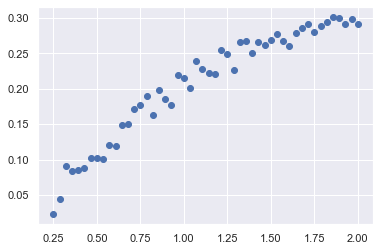

In [53]:
plt.scatter(search_space, growth_rates)
plt.show()

In [54]:
data = pd.DataFrame({'growth_rate': growth_rates, 'beta': search_space})

In [55]:
y, X = dmatrices('growth_rate ~ beta + I(beta**2) + I(beta**3)', data = data, return_type='dataframe')
mod_2 = sm.RLM(y, X)
res_2 = mod_2.fit()
print(res_2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            growth_rate   No. Observations:                   50
Model:                            RLM   Df Residuals:                       46
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 04 Mar 2022                                         
Time:                        18:54:38                                         
No. Iterations:                    14                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0537      0.017     -3.154   

Model selection suggest no quadratic component, we opt for linear regression model when estimating calibration values.

In [56]:
intercept = res_2.params['Intercept']
beta_coef = res_2.params['beta']
beta_coef_2 = res_2.params['I(beta ** 2)']
beta_coef_3 = res_2.params['I(beta ** 3)']

#beta_calibrated = (desired_growth_rate - intercept) / beta_coef

def estimate_growth_rate(beta):
    return intercept + beta_coef * beta + beta_coef_2 * beta**2 + beta_coef_3 * beta ** 3 

def objective_fun(beta, target_growth_rate):
    return abs(target_growth_rate - estimate_growth_rate(beta))

def get_calibrated_beta(target_growth_rate):
    objective_partial = partial(objective_fun, target_growth_rate = target_growth_rate)
    res = minimize_scalar(objective_partial, bracket = [1, 10])
    return round(res.x, 3)

In [57]:
target_growth_rates = [0.025, 0.05, 0.1,0.15,0.225,0.3]
calibration_dict = {growth_rate:get_calibrated_beta(growth_rate) for growth_rate in target_growth_rates}

In [58]:
calibration_dict

{0.025: 0.216, 0.05: 0.294, 0.1: 0.467, 0.15: 0.672, 0.225: 1.096, 0.3: 2.034}

## Trialing configured epidemic 
We try one of the scenarios with the most interventions to see if we still achieve a growing epidemic. If we don't have a growing epidemic, then it's much harder to infer the effectiveness of the interventions.

In [14]:
def run_simulation_with_interventions(beta: float, starting_infections: int, contact_scenario: str, pop_size: float, n_days: int, rand_seed: int):
    """Runs a simulation for a trial and returns a growth rate object

    Args:
        beta (float): trial 
        starting_infections (int): [description]
        contact_scenario (str): [description]
        pop_size (float): population size to trial

    Returns:
        FitGrowthRate: simulation growth rate analyzer object
    """

    ferretti_infectiousness = FerrettiInfectionDynamics()
    testing = testing_intervs[0.01]
    interventions = [testing, ili_ST_iso, pcr_symptomatic_testing, AZ_high, pfizer_high, dct]

    input_pars = copy(sim_pars)
    input_pars['pop_size'] = pop_size
    input_pars['beta'] = beta
    input_pars['n_days'] = n_days
    input_pars['rand_seed'] = rand_seed

    sim = cv.Sim(input_pars,
                pop_infected = starting_infections,
                interventions = interventions,
                infection_dynamics = ferretti_infectiousness,
                contact_matrices = contact_scenarios[contact_scenario],
                verbose = 0)

    sim.run()

    # pass to the objective function to evaluate the mismatch
    return FitGrowthRate(sim, growth_rate=0.0)

In [25]:
samples = [
    run_simulation_with_interventions(beta = 0.438, starting_infections=starting_infections, contact_scenario=contact_scenario, pop_size=pop_size, n_days=180, rand_seed=_)
    for _ in range(5)
]

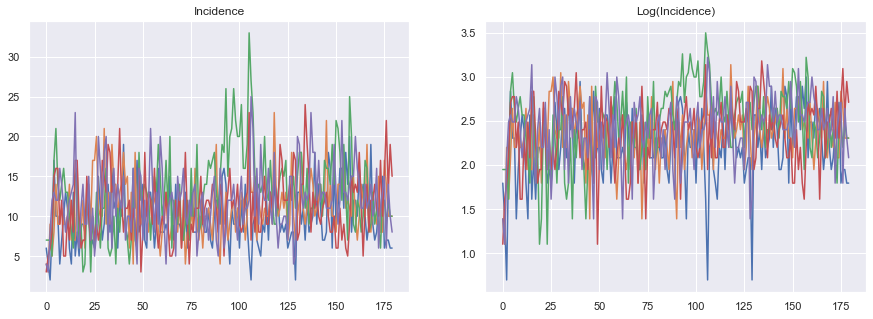

In [26]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

axs[0].set_title('Incidence')
axs[1].set_title('Log(Incidence)')

n_days = 180

for epidemic in samples:

    cases = epidemic.get_cases(day_from=0, day_to=n_days)

    axs[0].plot(range(len(cases)), cases)
    axs[1].plot(range(len(cases)), np.log(cases))

plt.show()

In [122]:
beta_calibrated

0.4145725607384752